# CVE Prophet Notebook From 2017 Forward

This notebook will pull all [JSON Data](https://nvd.nist.gov/vuln/data-feeds#JSON_FEED) from the NVD and performs some basic time series forecasting using [Prophet](https://facebook.github.io/prophet/) from Facebook.  

## Getting Started

### Retrieve The Data

This cell pulls all JSON files from the NVD that we will be working with.

In [1]:
%%capture
!pip3 install prophet
!mkdir -p jsondata
%cd jsondata
!rm *.json 
!rm *.zip 
!wget https://nvd.nist.gov/feeds/json/cve/1.1/nvdcve-1.1-{2017..2021}.json.zip 
!unzip -o "*.zip" 

(Note: The Output of this cell is hidden with `%%capture`)

### Import Python Libraries 

In [3]:
import calplot
import glob
import json
import logging
import sys
import numpy as np
import os
import pandas as pd
import re
import uuid
from datetime import datetime
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from scipy import stats
logging.disable(sys.maxsize)

### Build Base DataFrame

This code builds a Panda dataframe from the JSON files we downloaded, removing all CVE's marked rejected.

In [4]:
row_accumulator = []
for filename in glob.glob('*.json'):
    with open(filename, 'r', encoding='utf-8') as f:
        nvd_data = json.load(f)
        for entry in nvd_data['CVE_Items']:
            cve = entry['cve']['CVE_data_meta']['ID']
            try:
                published_date = entry['publishedDate']
            except KeyError:
                published_date = 'Missing_Data_JG'
            try:
                attack_vector = entry['impact']['baseMetricV3']['cvssV3']['attackVector']
            except KeyError:
                attack_vector = 'Missing_Data_JG'
            try:
                attack_complexity = entry['impact']['baseMetricV3']['cvssV3']['attackComplexity']
            except KeyError:
                attack_complexity = 'Missing_Data_JG'
            try:
                privileges_required = entry['impact']['baseMetricV3']['cvssV3']['privilegesRequired']
            except KeyError:
                privileges_required = 'Missing_Data_JG'
            try:
                user_interaction = entry['impact']['baseMetricV3']['cvssV3']['userInteraction']
            except KeyError:
                user_interaction = 'Missing_Data_JG'
            try:
                scope = entry['impact']['baseMetricV3']['cvssV3']['scope']
            except KeyError:
                scope = 'Missing_Data_JG'
            try:
                confidentiality_impact = entry['impact']['baseMetricV3']['cvssV3']['confidentialityImpact']
            except KeyError:
                confidentiality_impact = 'Missing_Data_JG'
            try:
                integrity_impact = entry['impact']['baseMetricV3']['cvssV3']['integrityImpact']
            except KeyError:
                integrity_impact = 'Missing_Data_JG'
            try:
                availability_impact = entry['impact']['baseMetricV3']['cvssV3']['availabilityImpact']
            except KeyError:
                availability_impact = 'Missing_Data_JG'
            try:
                base_score = entry['impact']['baseMetricV3']['cvssV3']['baseScore']
            except KeyError:
                base_score = 'Missing_Data_JG'
            try:
                base_severity = entry['impact']['baseMetricV3']['cvssV3']['baseSeverity']
            except KeyError:
                base_severity = 'Missing_Data_JG'
            try:
                exploitability_score = entry['impact']['baseMetricV3']['exploitabilityScore']
            except KeyError:
                exploitability_score = 'Missing_Data_JG'
            try:
                impact_score = entry['impact']['baseMetricV3']['impactScore']
            except KeyError:
                impact_score = 'Missing_Data_JG'
            try:
                cwe = entry['cve']['problemtype']['problemtype_data'][0]['description'][0]['value']
            except IndexError:
                cwe = 'Missing_Data_JG'
            try:
                description = entry['cve']['description']['description_data'][0]['value']
            except IndexError:
                description = ''
            new_row = { 
                'CVE': cve, 
                'Published': published_date,
                'AttackVector': attack_vector,
                'AttackComplexity': attack_complexity,
                'PrivilegesRequired': privileges_required,
                'UserInteraction': user_interaction,
                'Scope': scope,
                'ConfidentialityImpact': confidentiality_impact,
                'IntegrityImpact': integrity_impact,
                'AvailabilityImpact': availability_impact,
                'BaseScore': base_score,
                'BaseSeverity': base_severity,
                'ExploitabilityScore': exploitability_score,
                'ImpactScore': impact_score,
                'CWE': cwe,
                'Description': description
            }
            if not description.startswith('** REJECT **'): # disputed, rejected and other non issues start with '**'
                row_accumulator.append(new_row)
    nvd = pd.DataFrame(row_accumulator)

nvd['Published'] = pd.to_datetime(nvd['Published']).apply(lambda x: x.date())
print ('CVEs from NVD:', nvd['CVE'].count())
nvdcount = nvd['Published'].count()
nvdunique = nvd['Published'].nunique()
per_day = nvdcount/nvdunique
per_day = round(per_day, 0)
print('CVEs Published Per Publishing Day:', per_day)

CVEs from NVD: 75969
CVEs Published Per Publishing Day: 47.0


(Note: The code for building this dataframe is based off the great work in this [repo](https://github.com/joocer/mitre-tools/blob/74a08bca9e79f2c18cc4e8671d1d7da5b43a2dd4/source/data/02%20process_rawdata.py))

### Build Base DataFrame For Prophet 

In [5]:
cve_day = pd.DataFrame(nvd.Published.value_counts().reset_index().values, columns=["ds", "y"])
cve_day = cve_day.sort_index(axis = 0, ascending=True)
cve_day = cve_day[cve_day['y'] <= 400]  
cve_day.head(10)

,ds,y
2,2019-12-18,362
3,2018-02-15,315
4,2017-08-08,310
5,2019-09-27,309
6,2020-03-12,306
7,2018-06-11,303
8,2021-04-22,295
9,2021-09-08,278
10,2020-07-15,278
11,2018-10-17,261


There were ~5 days in the dataset that have between 400-1100 CVEs published. For this excercise I have removed them to correct the look of the graphs. 

### Build The Future Dataframe

In [6]:
m = Prophet()
m.fit(cve_day)
future = m.make_future_dataframe(periods=3650)

Initial log joint probability = -26.8902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2753.61   6.66179e-05       86.8051           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       2753.62   1.54886e-05       79.2935   1.616e-07       0.001      209  LS failed, Hessian reset 
     146       2753.62   1.30059e-07       75.2974      0.6198      0.6198      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


### Plot the Forecast

This shows the plot for all previous data and the next 10 years. 

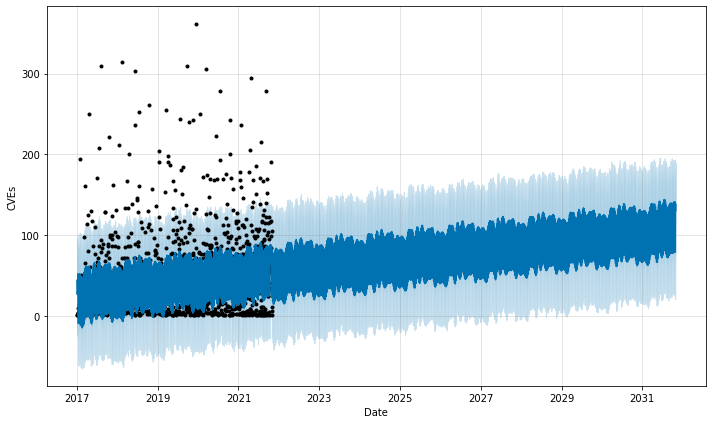

In [7]:
forecast = m.predict(future)
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs')
fig.savefig('./forecast.jpg', dpi=300, bbox_inches='tight')

### Plot the Forecast With Change Points

This shows the plot for all previous data and the next 10 years with changepoints marked where the data had abrupt changes in its trajectories.

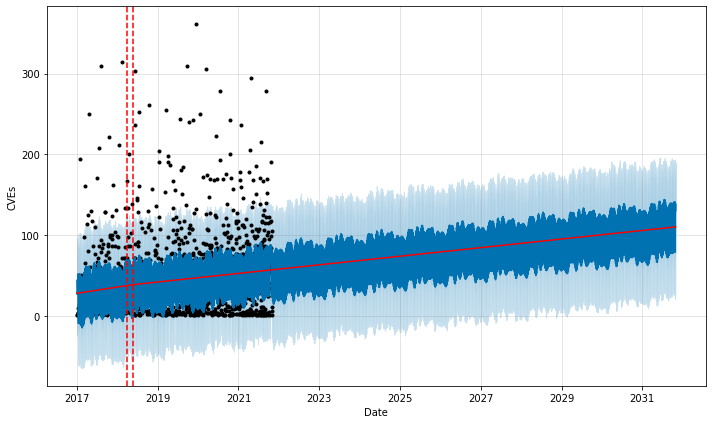

In [8]:
fig = m.plot(forecast, xlabel='Date', ylabel='CVEs')
a = add_changepoints_to_plot(fig.gca(), m, forecast)
fig.savefig('./forecast_changepoints.jpg', dpi=300, bbox_inches='tight')

### CVE Predictions For The Rest Of The Year

In [11]:
cve_prophet_thisyear = forecast[(forecast['ds'] > '2021-11-01') & (forecast['ds'] < '2021-12-31')]
cve_prophet_thisyear[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper
1664,2021-12-08,84.0,34.0,137.0
1671,2021-12-15,83.0,28.0,135.0
1657,2021-12-01,82.0,29.0,132.0
1629,2021-11-03,82.0,32.0,136.0
1678,2021-12-22,81.0,33.0,131.0
1685,2021-12-29,80.0,29.0,130.0
1650,2021-11-24,78.0,26.0,131.0
1636,2021-11-10,77.0,27.0,131.0
1643,2021-11-17,76.0,22.0,122.0
1665,2021-12-09,76.0,25.0,127.0


### CVE Predictions For The Next 5 Years

In [12]:
cve_prophet_next5 = forecast[(forecast['ds'] > '2021-11-01') & (forecast['ds'] < '2026-12-31')]
cve_prophet_next5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round(0).sort_values(by=['yhat'], ascending=False).head(10)

,ds,yhat,yhat_lower,yhat_upper
3351,2026-07-22,118.0,67.0,170.0
3344,2026-07-15,117.0,66.0,164.0
3442,2026-10-21,115.0,66.0,167.0
3358,2026-07-29,115.0,60.0,163.0
3302,2026-06-03,115.0,62.0,166.0
3309,2026-06-10,115.0,66.0,163.0
3435,2026-10-14,114.0,64.0,167.0
3449,2026-10-28,113.0,61.0,162.0
3428,2026-10-07,113.0,59.0,166.0
3414,2026-09-23,113.0,61.0,165.0


### CVE Predictions For The Next 10 Years

In [ ]:
by_year = forecast.copy()

result = by_year.groupby(by_year.ds.dt.to_period("Y"))['yhat'].sum().round()

for year, records in result.items():
    print(f"{year} - {records} CVEs")

2017 - 11175.0 CVEs
2018 - 14238.0 CVEs
2019 - 15870.0 CVEs
2020 - 17351.0 CVEs
2021 - 19572.0 CVEs
2022 - 21704.0 CVEs
2023 - 23522.0 CVEs
2024 - 25456.0 CVEs
2025 - 27219.0 CVEs
2026 - 29030.0 CVEs
2027 - 30835.0 CVEs
2028 - 32664.0 CVEs
2029 - 34469.0 CVEs
2030 - 36297.0 CVEs
2031 - 24418.0 CVEs
